# Examples showcasing GEM EO BYOC data collections

This is a notebook showcasing workflow examples for downloading EO data from BYOC data collections available through Sentinel Hub.

### Data download examples in this notebook:

1.  Sentinel-2 L2A mosaic for Africa

2.  Meteoblue weather data for Africa


In [1]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np

from eolearn.core import FeatureType
from eolearn.io import SentinelHubEvalscriptTask
from sentinelhub import CRS, Band, BBox, DataCollection, Unit

In [2]:
bbox = BBox(bbox=[-18, 1, 27.5, 28], crs=CRS.WGS84)

## Sentinel-2 L2A mosaic for Africa

In [3]:
band_names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B11", "B12", "B8A"]

africa_s2_data_collection = DataCollection.define_byoc(
    "fe60e85f-0648-4c54-b2dc-bbf725033813",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.uint16,)) for name in band_names],
)

In [4]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B01","B02","B03","B04","B05","B06","B07","B08","B09","B11","B12","B8A"],
    output: [
        {
          id: "bands",
          bands: 12,
          sampleType: "UINT16"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.B01, sample.B02, sample.B03, sample.B04, sample.B05, sample.B06, sample.B07, sample.B08, sample.B09, sample.B11, sample.B12, sample.B8A];
}
"""

In [5]:
download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript,
    data_collection=africa_s2_data_collection,
    resolution=5000,
    max_threads=3,
)

In [6]:
eopatch = download_task.execute(bbox=bbox, time_interval=["2020-08-01", "2020-08-30"])

In [7]:
eopatch

EOPatch(
  data={
    bands: numpy.ndarray(shape=(1, 647, 968, 12), dtype=uint16)
  }
  meta_info={
    size_x: 968
    size_y: 647
    time_difference: 1.0
    time_interval: ('2020-08-01T00:00:00', '2020-08-30T23:59:59')
  }
  bbox=BBox(((-18.0, 1.0), (27.5, 28.0)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 8, 1, 0, 0)]
)

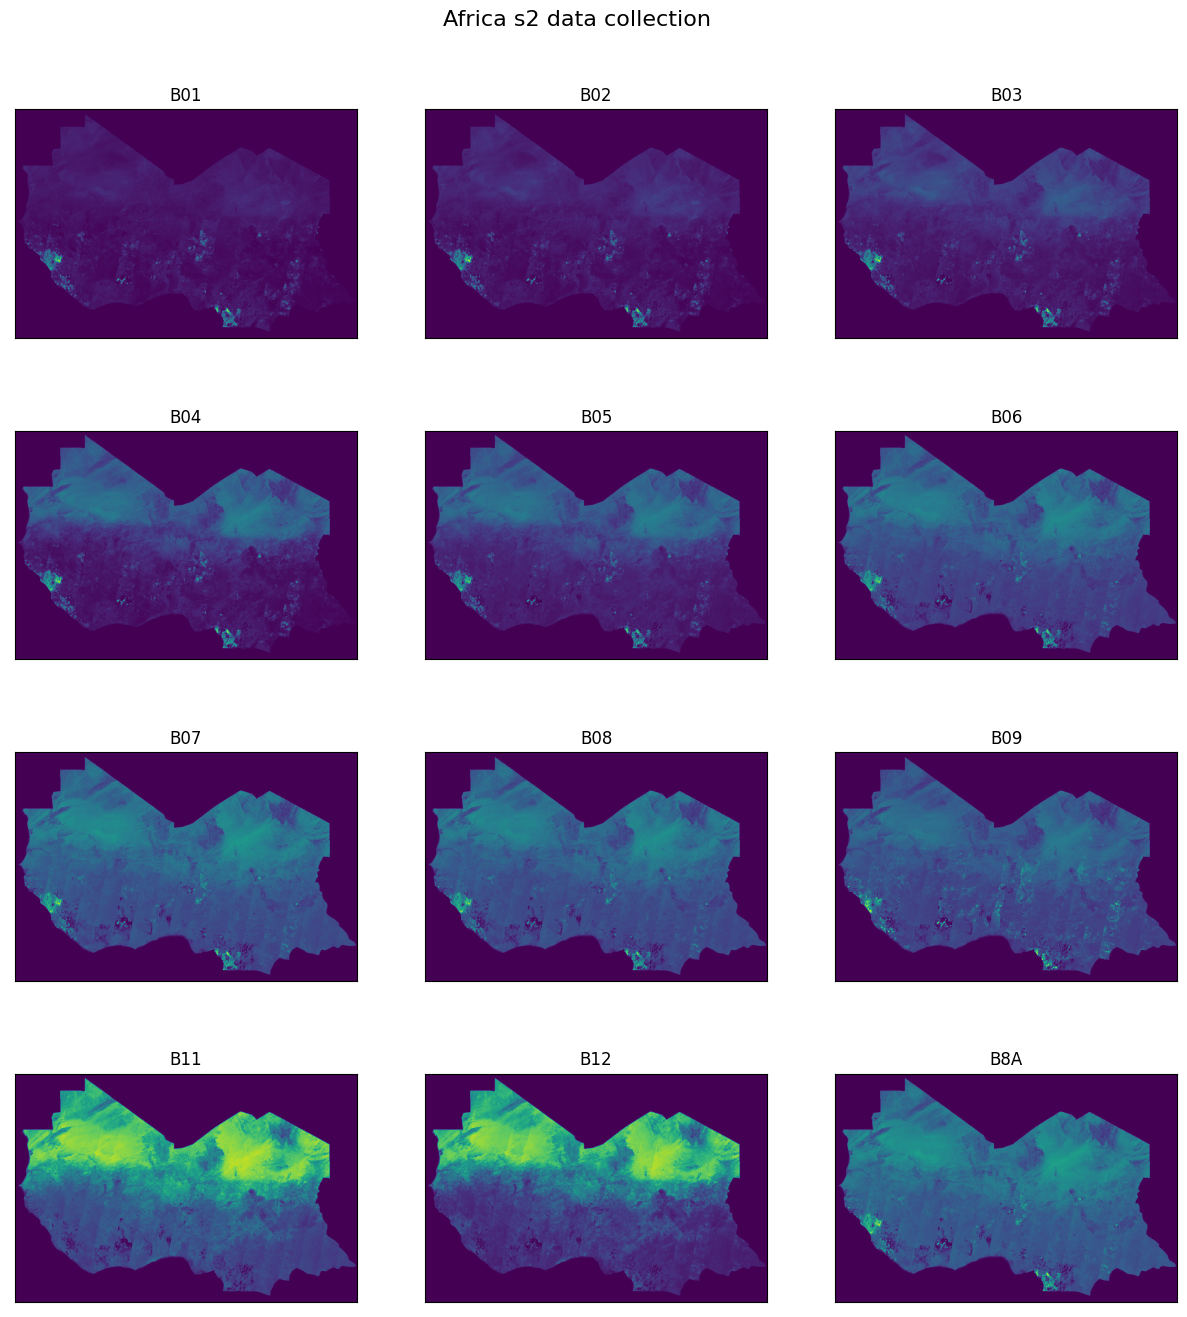

In [8]:
ncols = 3
nrows = math.ceil(len(band_names) / 3)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4 * nrows))
fig.suptitle("Africa s2 data collection", y=0.93, size=16)

for idx, band in enumerate(band_names):
    ax[idx // ncols][idx % ncols].imshow(eopatch.data["bands"][0][..., idx].squeeze())
    ax[idx // ncols][idx % ncols].set_title(band_names[idx], size=12)
    ax[idx // ncols][idx % ncols].get_xaxis().set_visible(False)
    ax[idx // ncols][idx % ncols].get_yaxis().set_visible(False)

In [9]:
evalscript_true_color = """
//VERSION=3
function setup() {
  return {
    input: ["B02","B03","B04"],
    output: [
        {
          id: "bands",
          bands: 3,
          sampleType: "UINT16"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.B02, sample.B03, sample.B04];
}
"""

In [10]:
download_task_true_color = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript_true_color,
    data_collection=africa_s2_data_collection,
    resolution=5000,
    max_threads=3,
)

In [11]:
eopatch_true_color = download_task_true_color.execute(bbox=bbox, time_interval=["2020-01-01", "2020-12-30"])

In [12]:
eopatch_true_color

EOPatch(
  data={
    bands: numpy.ndarray(shape=(12, 647, 968, 3), dtype=uint16)
  }
  meta_info={
    size_x: 968
    size_y: 647
    time_difference: 1.0
    time_interval: ('2020-01-01T00:00:00', '2020-12-30T23:59:59')
  }
  bbox=BBox(((-18.0, 1.0), (27.5, 28.0)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 1, 1, 0, 0), ..., datetime.datetime(2020, 12, 1, 0, 0)], length=12
)

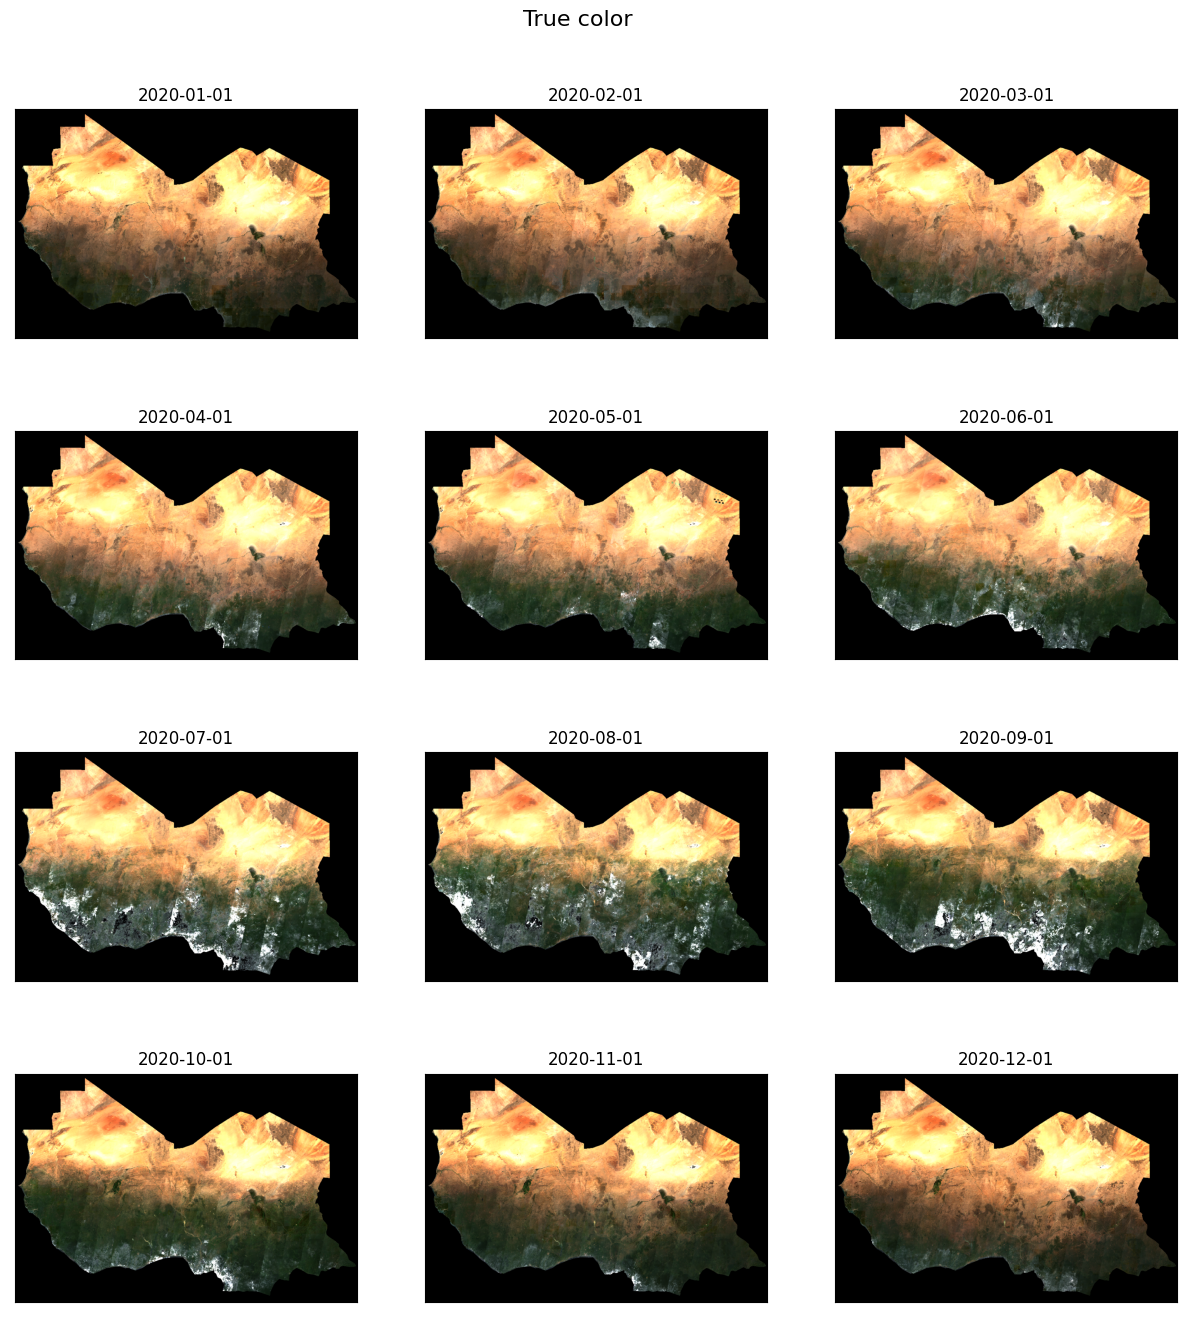

In [13]:
ncols = 3
nrows = math.ceil(len(eopatch_true_color.timestamp) / 3)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4 * nrows))
fig.suptitle("True color", y=0.93, size=16)

for idx, _ in enumerate(eopatch_true_color.timestamp):
    ax[idx // ncols][idx % ncols].imshow(
        np.clip(eopatch_true_color.data["bands"][idx][:, :, [2, 1, 0]].squeeze() / 10000 * 3, 0, 1)
    )
    ax[idx // ncols][idx % ncols].set_title(str(eopatch_true_color.timestamp[idx])[:10], size=12)
    ax[idx // ncols][idx % ncols].get_xaxis().set_visible(False)
    ax[idx // ncols][idx % ncols].get_yaxis().set_visible(False)

## Meteoblue weather data for Africa

In [14]:
band_names = [
    "CLOUD_COVER_TOTAL",
    "HUMIDITY",
    "PRECIPITATION",
    "PRESSURE",
    "SOIL_MOISTURE",
    "SUN_DURATION",
    "TEMPERATURE",
    "VAPOR_PRESSURE_DEFICIT",
    "WIND",
]

S2_africa_weather_data_collection = DataCollection.define_byoc(
    "0013507a-de28-4800-a890-394c493a51a3",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)

In [15]:
evalscript_weather = """
//VERSION=3
function setup() {
  return {
    input: ["CLOUD_COVER_TOTAL", "HUMIDITY", "PRECIPITATION", "PRESSURE","SOIL_MOISTURE", "SUN_DURATION", "TEMPERATURE", "VAPOR_PRESSURE_DEFICIT", "WIND"],
    output: [
        {
          id: "bands",
          bands: 9,
          sampleType: "FLOAT32"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.CLOUD_COVER_TOTAL, sample.HUMIDITY, sample.PRECIPITATION, sample.PRESSURE, sample.SOIL_MOISTURE, sample.SUN_DURATION, sample.TEMPERATURE, sample.VAPOR_PRESSURE_DEFICIT, sample.WIND];
}
"""

In [16]:
download_task_weather = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript_weather,
    data_collection=S2_africa_weather_data_collection,
    resolution=5000,
    max_threads=3,
)

In [17]:
eopatch_weather = download_task_weather.execute(bbox=bbox, time_interval=["2020-08-01", "2020-08-30"])

In [18]:
eopatch_weather

EOPatch(
  data={
    bands: numpy.ndarray(shape=(1, 647, 968, 9), dtype=float32)
  }
  meta_info={
    size_x: 968
    size_y: 647
    time_difference: 1.0
    time_interval: ('2020-08-01T00:00:00', '2020-08-30T23:59:59')
  }
  bbox=BBox(((-18.0, 1.0), (27.5, 28.0)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 8, 1, 0, 0)]
)

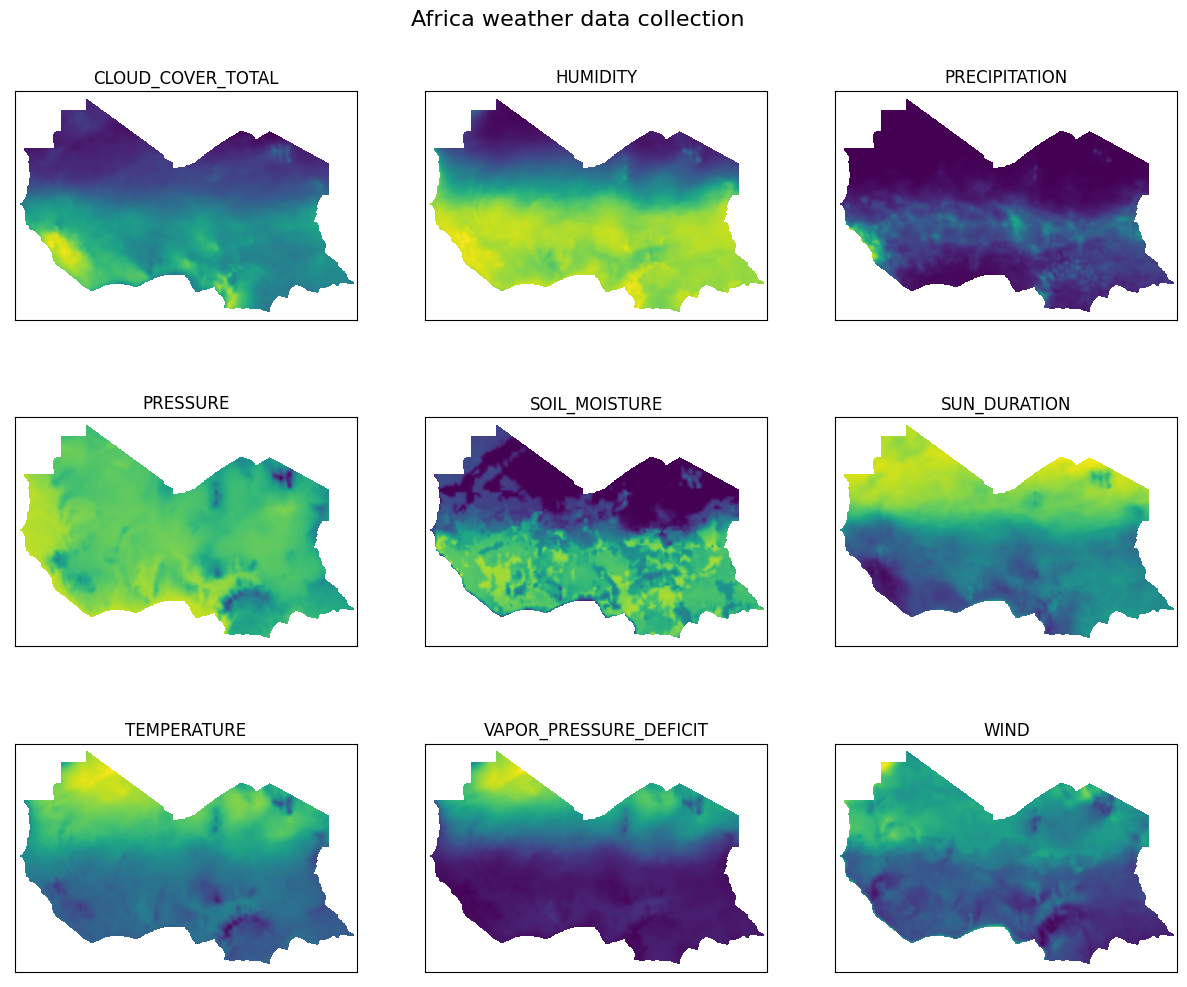

In [19]:
ncols = 3
nrows = math.ceil(len(band_names) / 3)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4 * nrows))
fig.suptitle("Africa weather data collection", y=0.93, size=16)

for idx, band in enumerate(band_names):
    ax[idx // ncols][idx % ncols].imshow(eopatch_weather.data["bands"][0][..., idx].squeeze())
    ax[idx // ncols][idx % ncols].set_title(band_names[idx], size=12)
    ax[idx // ncols][idx % ncols].get_xaxis().set_visible(False)
    ax[idx // ncols][idx % ncols].get_yaxis().set_visible(False)

In [20]:
evalscript_precipitation = """
//VERSION=3
function setup() {
  return {
    input: [ "PRECIPITATION"],
    output: [
        {
          id: "bands",
          bands: 1,
          sampleType: "FLOAT32"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.PRECIPITATION];
}
"""

In [21]:
ps_download_task_precipitation = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript_precipitation,
    data_collection=S2_africa_weather_data_collection,
    resolution=5000,
    max_threads=3,
)

In [22]:
eopatch_precipitation = ps_download_task_precipitation.execute(bbox=bbox, time_interval=["2020-01-01", "2020-12-30"])

In [23]:
eopatch_precipitation

EOPatch(
  data={
    bands: numpy.ndarray(shape=(12, 647, 968, 1), dtype=float32)
  }
  meta_info={
    size_x: 968
    size_y: 647
    time_difference: 1.0
    time_interval: ('2020-01-01T00:00:00', '2020-12-30T23:59:59')
  }
  bbox=BBox(((-18.0, 1.0), (27.5, 28.0)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 1, 1, 0, 0), ..., datetime.datetime(2020, 12, 1, 0, 0)], length=12
)

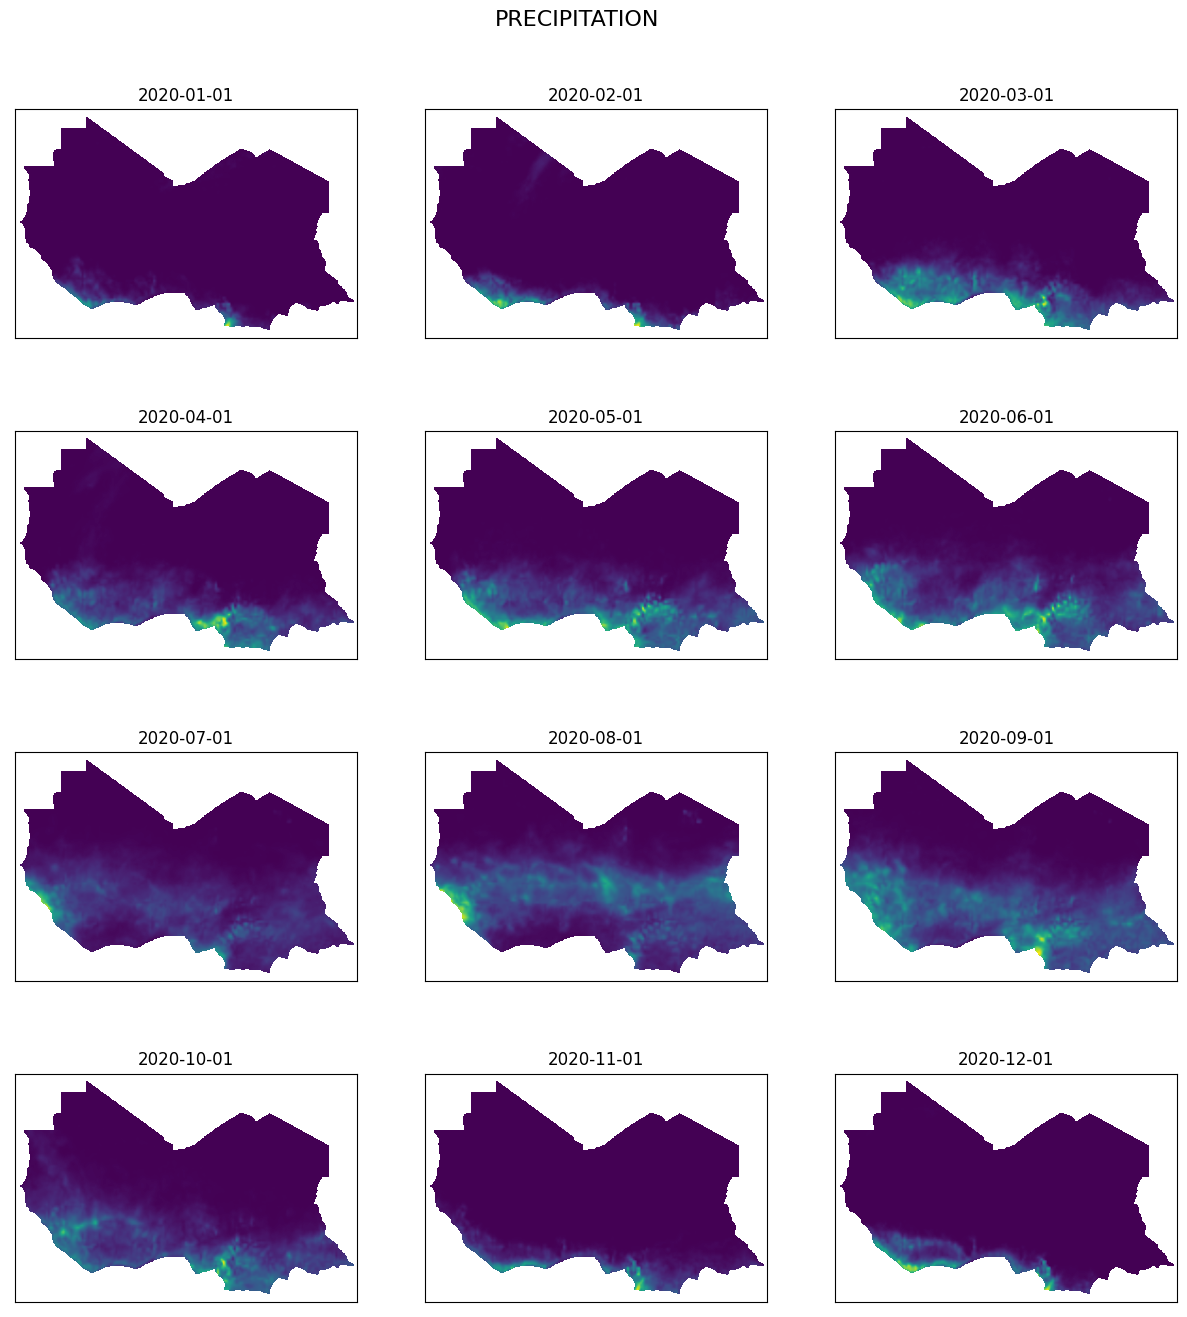

In [24]:
ncols = 3
nrows = math.ceil(len(eopatch_precipitation.timestamp) / 3)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4 * nrows))
fig.suptitle("PRECIPITATION", y=0.93, size=16)

for idx, _ in enumerate(eopatch_precipitation.timestamp):
    ax[idx // ncols][idx % ncols].imshow(eopatch_precipitation.data["bands"][idx][...].squeeze())
    ax[idx // ncols][idx % ncols].set_title(str(eopatch_precipitation.timestamp[idx])[:10], size=12)
    ax[idx // ncols][idx % ncols].get_xaxis().set_visible(False)
    ax[idx // ncols][idx % ncols].get_yaxis().set_visible(False)